In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/final_grape_data.zip

Archive:  /content/drive/MyDrive/final_grape_data.zip
   creating: final_grape_data/image/
  inflating: final_grape_data/image/1 (1).png  
  inflating: final_grape_data/image/1 (10).png  
  inflating: final_grape_data/image/1 (100).png  
  inflating: final_grape_data/image/1 (101).png  
  inflating: final_grape_data/image/1 (102).png  
  inflating: final_grape_data/image/1 (103).png  
  inflating: final_grape_data/image/1 (104).png  
  inflating: final_grape_data/image/1 (105).png  
  inflating: final_grape_data/image/1 (106).png  
  inflating: final_grape_data/image/1 (107).png  
  inflating: final_grape_data/image/1 (108).png  
  inflating: final_grape_data/image/1 (109).png  
  inflating: final_grape_data/image/1 (11).png  
  inflating: final_grape_data/image/1 (110).png  
  inflating: final_grape_data/image/1 (111).png  
  inflating: final_grape_data/image/1 (112).png  
  inflating: final_grape_data/image/1 (113).png  
  inflating: final_grape_data/image/1 (114).png  
  inflating: 

In [47]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from keras.layers import Input, UpSampling2D,BatchNormalization, ZeroPadding2D, Reshape, Permute
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import os
import cv2

In [64]:
def res_unet(filter_root, depth, n_class=1, input_size=(256, 256, 1), activation='relu', batch_norm=True, final_activation='sigmoid'):

    inputs = Input(input_size)
    x = inputs
    long_connection_store = {}


    for i in range(depth):
        out_channel = 2**i * filter_root
        res = Conv2D(out_channel, kernel_size=1, padding='same', use_bias=False, name="Identity{}_1".format(i))(x)

        conv1 = Conv2D(out_channel, kernel_size=3, padding='same', name="Conv{}_1".format(i))(x)
        if batch_norm:
            conv1 = BatchNormalization(name="BN{}_1".format(i))(conv1)
        act1 = Activation(activation, name="Act{}_1".format(i))(conv1)

        conv2 = Conv2D(out_channel, kernel_size=3, padding='same', name="Conv{}_2".format(i))(act1)
        if batch_norm:
            conv2 = BatchNormalization(name="BN{}_2".format(i))(conv2)

        resconnection = Add(name="Add{}_1".format(i))([res, conv2])

        act2 = Activation(activation, name="Act{}_2".format(i))(resconnection)

        if i < depth - 1:
            long_connection_store[str(i)] = act2
            x = MaxPooling2D(padding='same', name="MaxPooling{}_1".format(i))(act2)
        else:
            x = act2

    for i in range(depth - 2, -1, -1):
        out_channel = 2**(i) * filter_root

        long_connection = long_connection_store[str(i)]

        up1 = UpSampling2D()(x)
        up_conv1 = Conv2D(out_channel, 2, activation='relu', padding='same')(up1)

        #  Concatenate.
        up_conc = Concatenate(axis=-1)([up_conv1, long_connection])

        #  Convolutions
        up_conv2 = Conv2D(out_channel, 3, padding='same')(up_conc)
        if batch_norm:
            up_conv2 = BatchNormalization()(up_conv2)
        up_act1 = Activation(activation)(up_conv2)

        up_conv2 = Conv2D(out_channel, 3, padding='same')(up_act1)
        if batch_norm:
            up_conv2 = BatchNormalization()(up_conv2)

        # Residual/Skip connection
        res = Conv2D(out_channel, kernel_size=1, padding='same', use_bias=False)(up_conc)

        resconnection = Add()([res, up_conv2])

        x = Activation(activation)(resconnection)

    # Final convolution
    output = Conv2D(n_class, 1, padding='same', activation=final_activation)(x)

    return Model(inputs, outputs=output)

In [65]:
def read_and_preprocess_images(folder_path, target_size=(128, 128), grayscale=False):
    images = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            if grayscale:
                image = cv2.imread(image_path, 0)
                image = np.expand_dims(image, axis=-1)
            else:
                image = cv2.imread(image_path)
            image = image.astype(np.float32) / 255.0
            image = cv2.resize(image, target_size)
            images.append(image)
    return np.array(images)

In [66]:
images = read_and_preprocess_images('/content/final_grape_data/image', target_size=(256, 256),grayscale=True)
masks = read_and_preprocess_images('/content/final_grape_data/mask', target_size=(256, 256), grayscale=True)

In [67]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_train = np.array(images_train)
masks_train = np.array(masks_train)
images_test = np.array(images_test)
masks_test = np.array(masks_test)

#masks_train = to_categorical(masks_train, num_classes=2)
#masks_test = to_categorical(masks_test, num_classes=2)

In [68]:
from keras.optimizers import Adam

model = res_unet(32, 4)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(images_train, masks_train,
                    batch_size = 8,
                    epochs = 35,
                    validation_data = (images_test, masks_test))

Epoch 1/35
83/83 [==============================] - 30s 256ms/step - loss: 0.1956 - accuracy: 0.9070 - val_loss: 0.4683 - val_accuracy: 0.8665
Epoch 2/35
83/83 [==============================] - 19s 225ms/step - loss: 0.0693 - accuracy: 0.9532 - val_loss: 0.9006 - val_accuracy: 0.8665
Epoch 3/35
83/83 [==============================] - 19s 223ms/step - loss: 0.0611 - accuracy: 0.9553 - val_loss: 0.9471 - val_accuracy: 0.8665
Epoch 4/35
83/83 [==============================] - 19s 224ms/step - loss: 0.0488 - accuracy: 0.9589 - val_loss: 0.8962 - val_accuracy: 0.8665
Epoch 5/35
83/83 [==============================] - 19s 225ms/step - loss: 0.0406 - accuracy: 0.9617 - val_loss: 0.5283 - val_accuracy: 0.8784
Epoch 6/35
83/83 [==============================] - 19s 226ms/step - loss: 0.0418 - accuracy: 0.9611 - val_loss: 0.3318 - val_accuracy: 0.9056
Epoch 7/35
83/83 [==============================] - 19s 225ms/step - loss: 0.0334 - accuracy: 0.9638 - val_loss: 0.1103 - val_accuracy: 0.9516

In [99]:
results = model.predict(images_test)
pred_mask = np.squeeze(np.where(results > 0.3, 1, 0), axis=-1)

6/6 [==============================] - 1s 239ms/step


In [100]:
results[0].shape

(256, 256, 1)

In [101]:
loss, acc = model.evaluate(images_test, masks_test)
loss, acc

6/6 [==============================] - 1s 208ms/step - loss: 0.0168 - accuracy: 0.9733


(0.016807809472084045, 0.973322868347168)

In [102]:
model.save('resnet34_unet.h5')

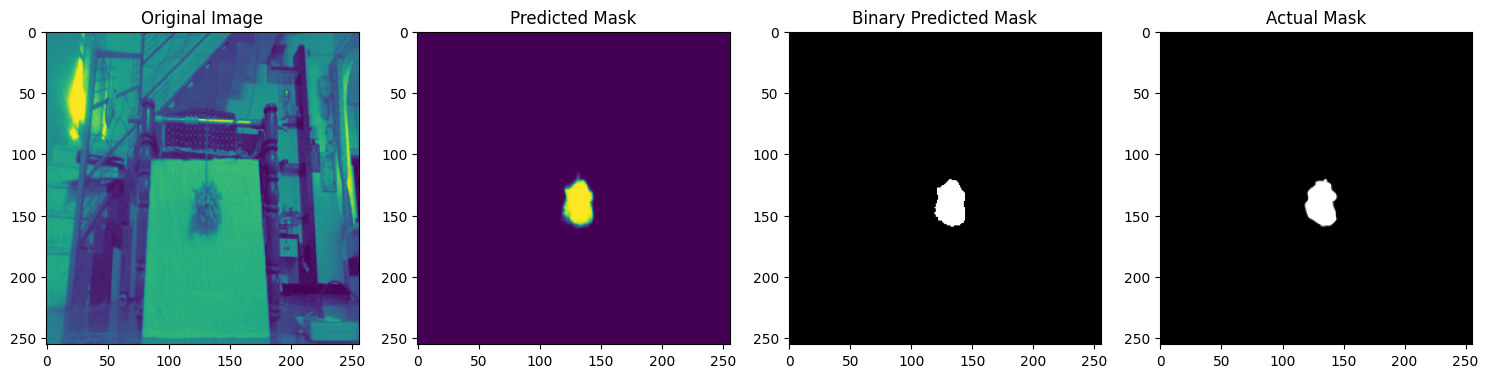

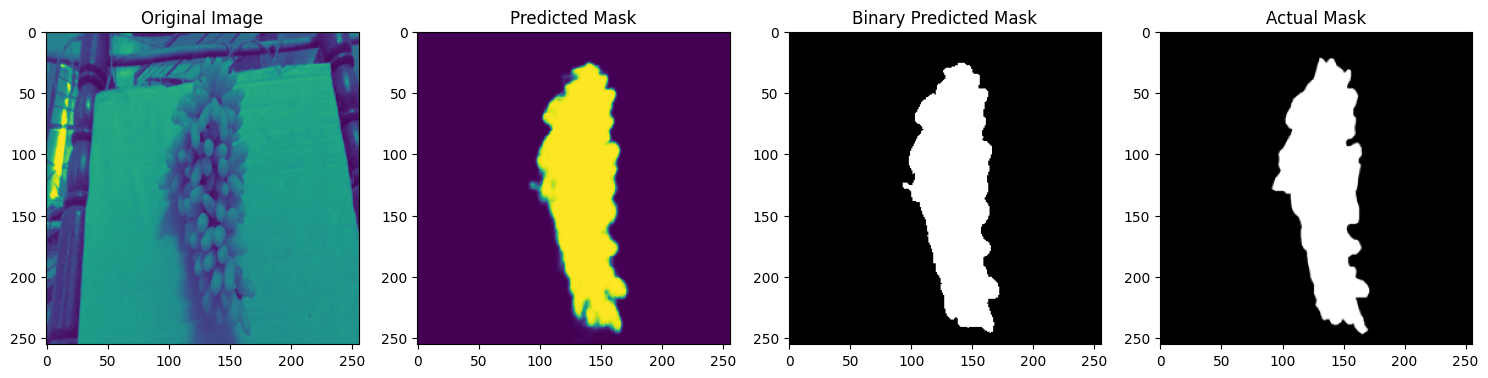

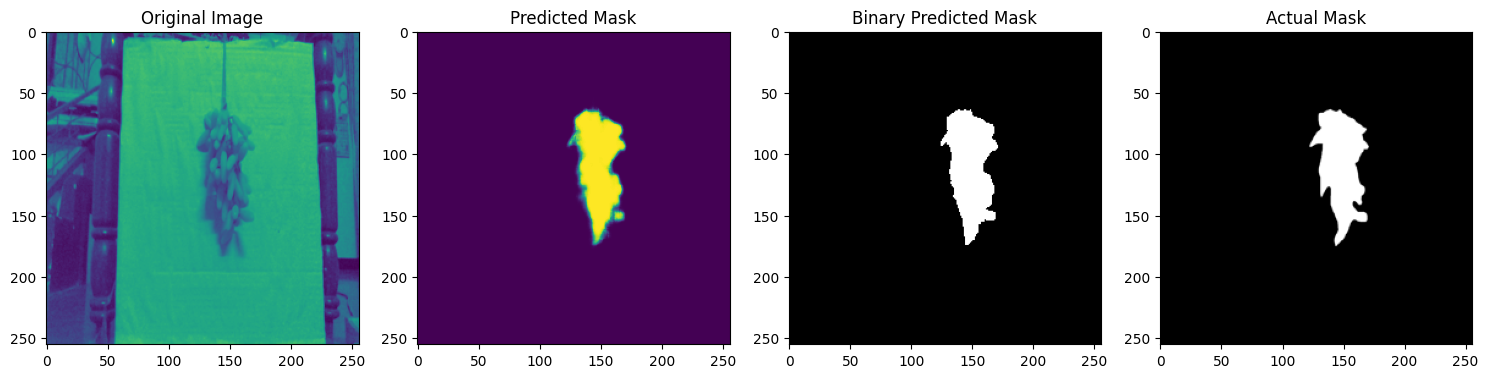

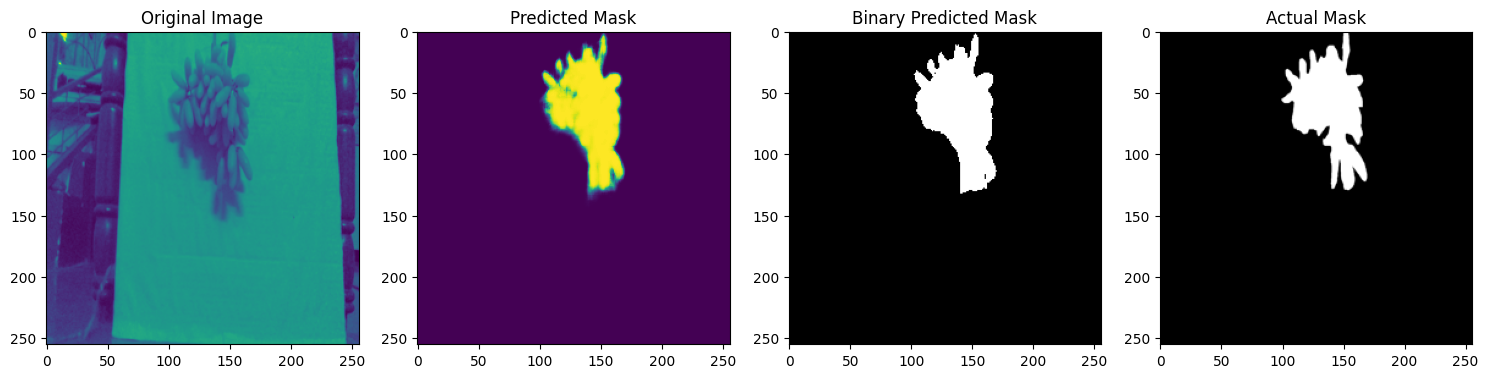

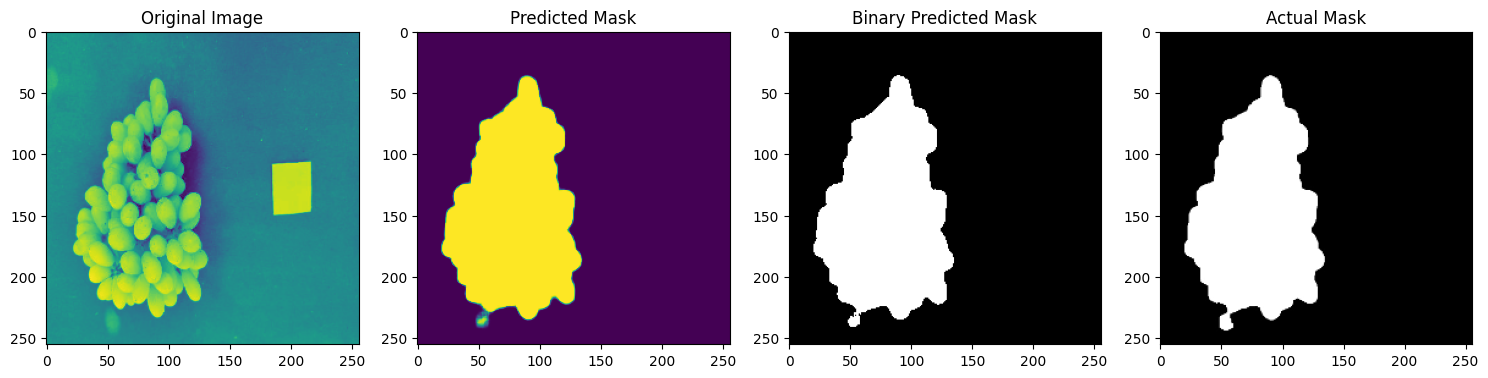

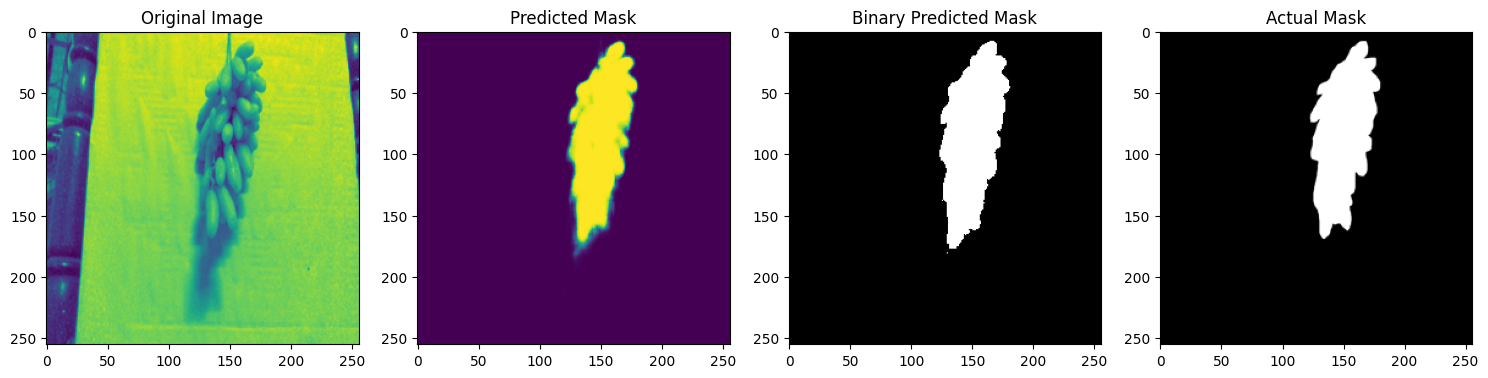

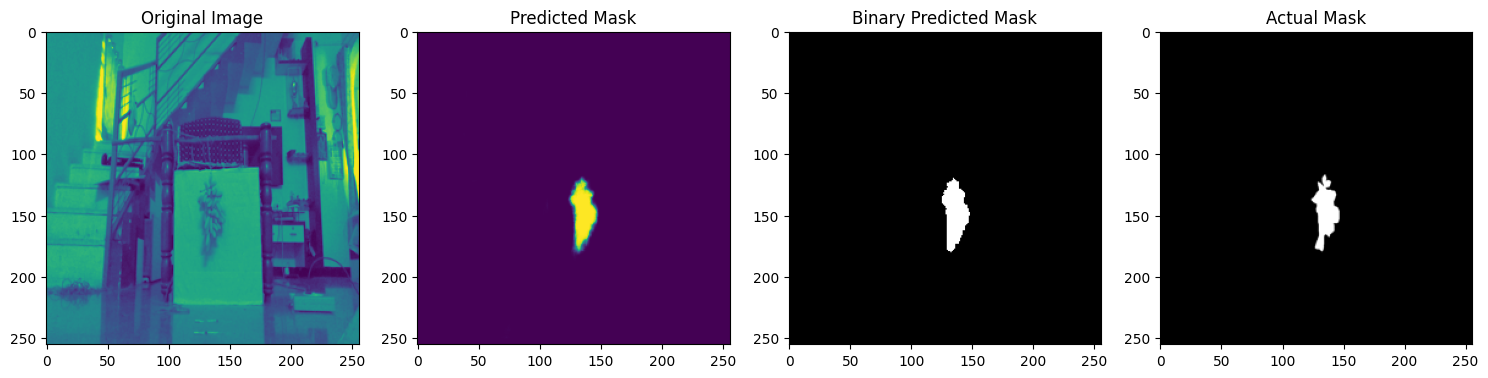

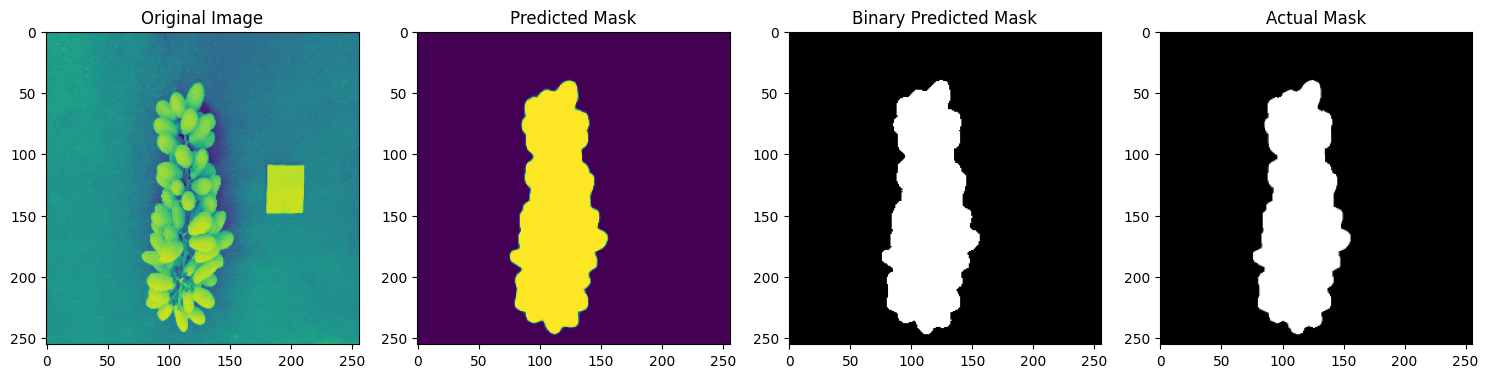

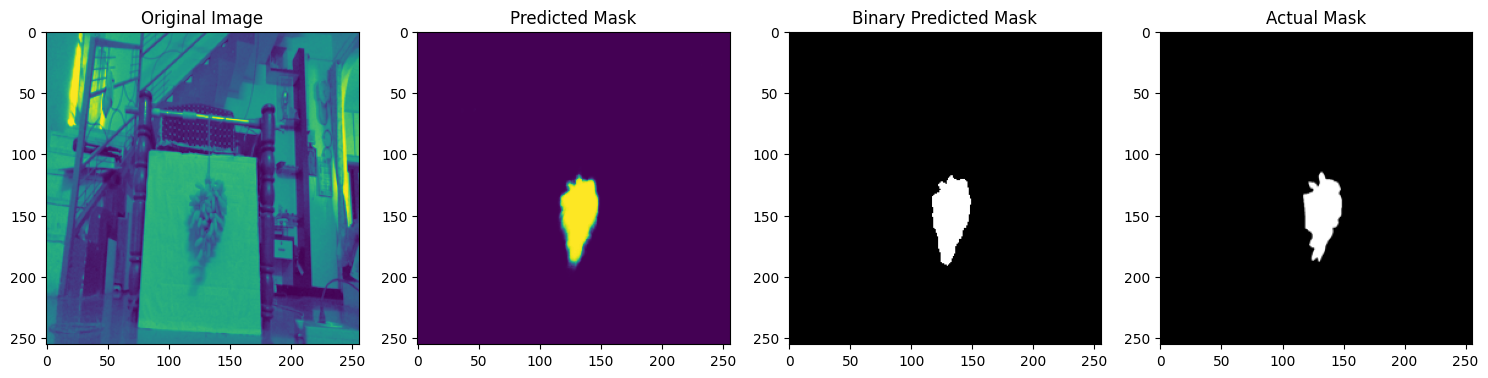

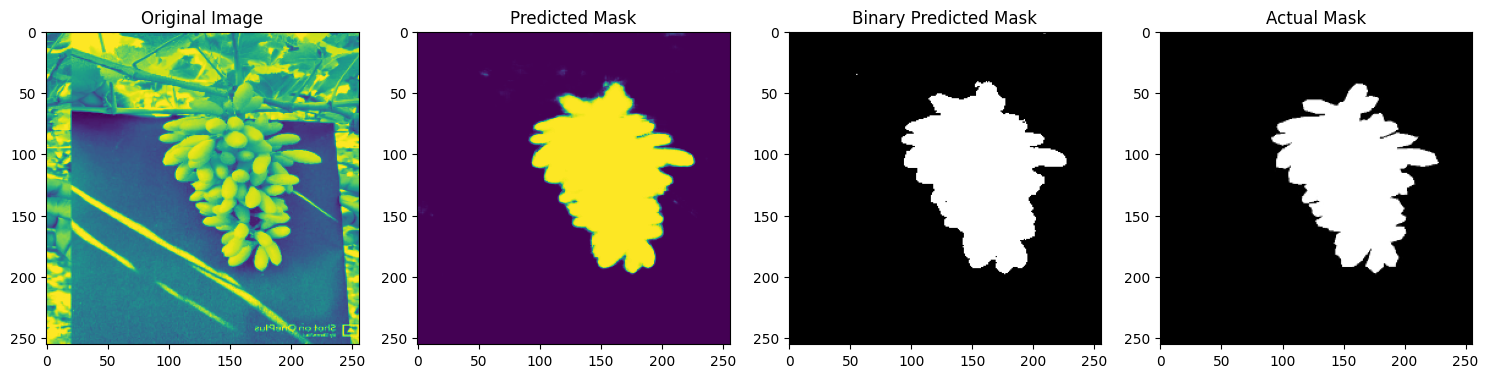

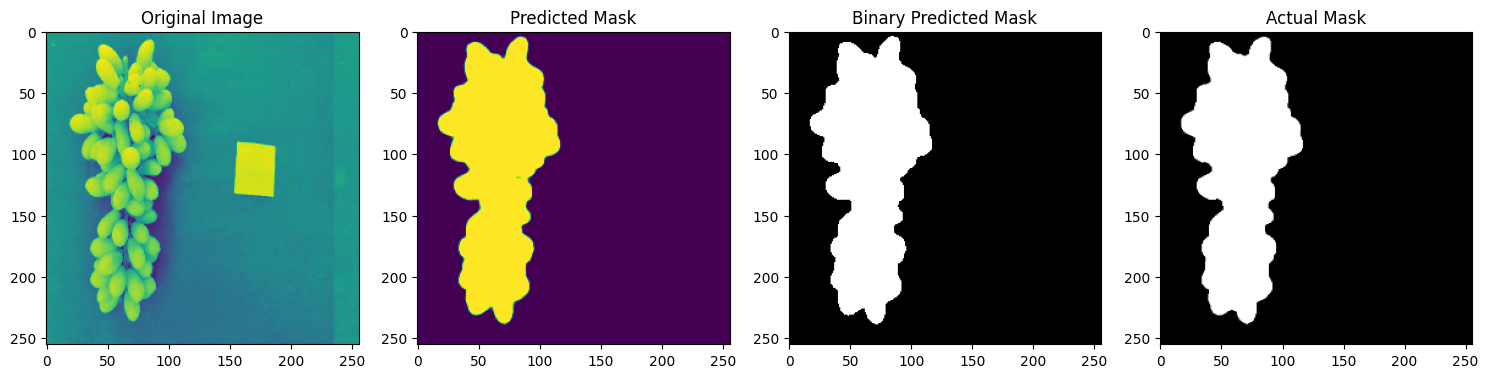

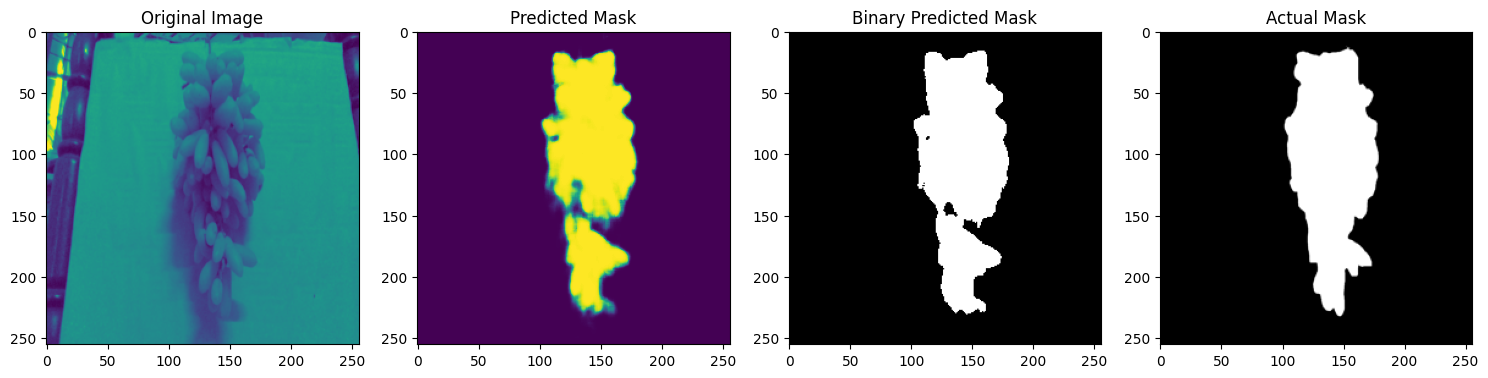

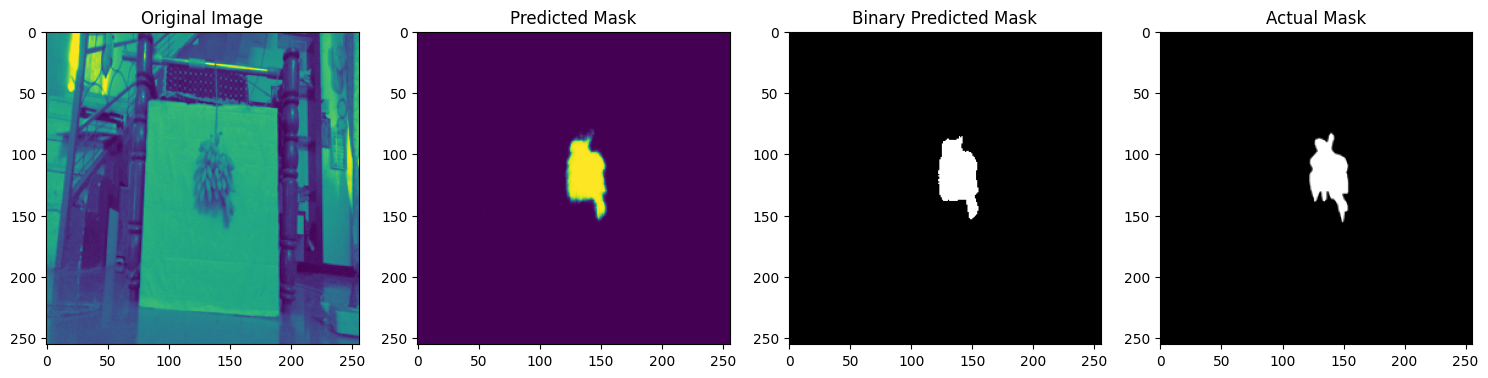

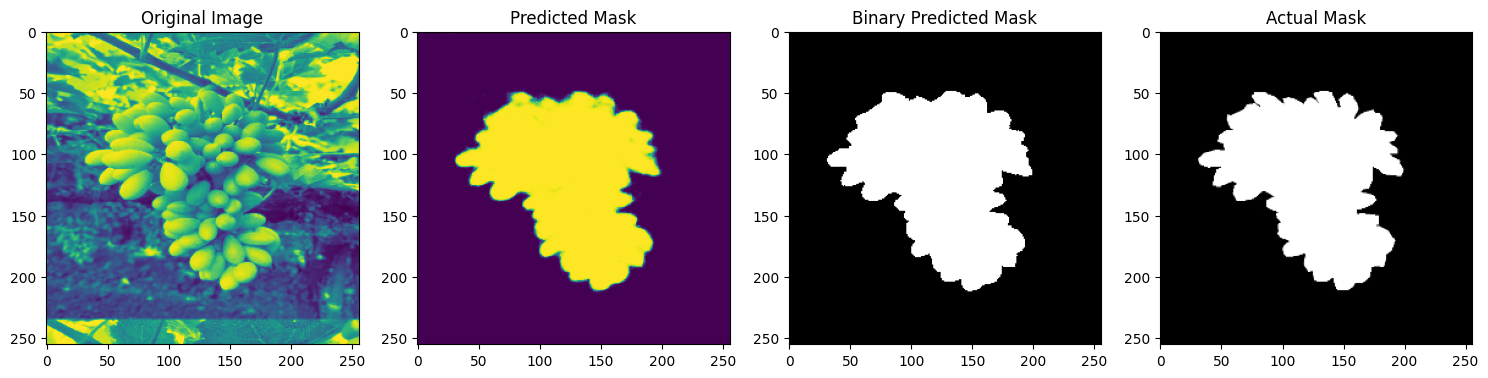

In [103]:
for i in range(20):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(images_test[i])
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(results[i])
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask[i], cmap='gray')
    plt.title('Binary Predicted Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(masks_test[i], cmap='gray')
    plt.title('Actual Mask')
    plt.tight_layout()
    plt.show()

In [104]:
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def compute_dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_coefficient = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_coefficient


iou = compute_iou(pred_mask, masks_test)
dice_coefficient = compute_dice_coefficient(pred_mask, masks_test)

print("IoU:", iou)
print("Dice Coefficient:", dice_coefficient)

IoU: 0.9023738714961281
Dice Coefficient: 0.9739952142108846


In [105]:
def compute_dice_loss(y_true, y_pred):
    dice_loss = 1 - compute_dice_coefficient(y_true, y_pred)
    return dice_loss

def compute_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = 1e-7
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    focal_loss = - (alpha * y_true * ((1 - y_pred) ** gamma) * np.log(y_pred) +
                    (1 - alpha) * (1 - y_true) * (y_pred ** gamma) * np.log(1 - y_pred))
    return focal_loss.mean()

dice_loss = compute_dice_loss(pred_mask, masks_test)
focal_loss = compute_focal_loss(pred_mask, masks_test)

print("Dice Loss:", dice_loss)
print("Focal Loss:", focal_loss)

Dice Loss: 0.02600478578911536
Focal Loss: 0.02111057345701288
